In [1]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langsmith import traceable
from dotenv import load_dotenv
import os

In [2]:
load_dotenv()

os.environ['LANGCHAIN_PROJECT']='SubGraph Shared demo'

model = ChatOpenAI()

parser = StrOutputParser()

In [3]:
class ParentState(TypedDict):

    question : str
    eng_ans : str
    hindi_ans : str

In [4]:
@traceable(name='Sub Graph translation',tags=['SubGraph Translation'],metadata={'dimension':'translation'})
def translate(state:ParentState)->dict:

    eng_ans = state['eng_ans']

    template = PromptTemplate(
        template = """
            Translate the following text to Hindi.
            Keep it natural and clear. Do not add extra content.
            Text:
            {eng_ans}
        """,
        input_variables=['eng_ans']
    )

    chain = template | model | parser

    response = chain.invoke({'eng_ans':eng_ans})

    return {'hindi_ans':response}

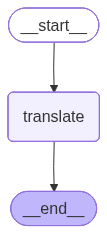

In [5]:
sub_graph = StateGraph(ParentState)

sub_graph.add_node('translate',translate)

sub_graph.add_edge(START,'translate')
sub_graph.add_edge('translate',END)

sub_chat = sub_graph.compile()

sub_chat = sub_graph.compile()

sub_chat


In [6]:
@traceable(name='Generate Answer',tags=['Generate Answer'],metadata={'dimension':'Generate Answer'})
def generate_ans(state:ParentState)->dict:

    question = state['question']

    template = PromptTemplate(
        template = 'You are a helpful assistant. Answer clearly.\n\nQuestion:{question}'
    )

    chain = template | model | parser

    response = chain.invoke({'question':question})

    return {'eng_ans':response}

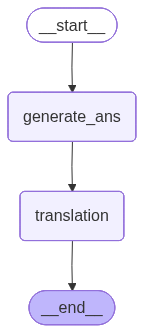

In [7]:
parent_graph = StateGraph(ParentState)

parent_graph.add_node('generate_ans',generate_ans)
parent_graph.add_node('translation',sub_chat)

parent_graph.add_edge(START,'generate_ans')
parent_graph.add_edge('generate_ans','translation')
parent_graph.add_edge('translation',END)

parent_bot = parent_graph.compile()

parent_bot

In [8]:
@traceable(name='Main Pipeline',tags=['Final_pipeline'],metadata={'dimension':'final'})
def main_pipeline():

    parent_graph = StateGraph(ParentState)

    parent_graph.add_node('generate_ans',generate_ans)
    parent_graph.add_node('translation',sub_chat)

    parent_graph.add_edge(START,'generate_ans')
    parent_graph.add_edge('generate_ans','translation')
    parent_graph.add_edge('translation',END)

    parent_bot = parent_graph.compile()

    parent_bot

    response = parent_bot.invoke({'question':'What is the role of AI in new job'},config={"run_name": "sub_graph_trace"})

    return response

In [9]:
if __name__ == '__main__':

    response = main_pipeline()

    print(response['question'])
    print(response['eng_ans'])
    print(response['hindi_ans'])

What is the role of AI in new job
AI plays a significant role in creating new job opportunities by automating repetitive tasks, improving efficiency, and enabling businesses to make data-driven decisions. AI also helps in streamlining processes, enhancing customer experiences, and reducing human error in various industries. Additionally, AI can create jobs in fields such as data science, AI engineering, and automation technology.
एआई नकली कार्यों को स्वचालित करके नए रोजगार के अवसर सृजित करने में महत्वपूर्ण भूमिका निभाती है, कार्यक्षमता में सुधार करती है, और व्यवसायों को डेटा-आधारित निर्णय लेने में सक्षम बनाती है। एआई अभिभावन प्रक्रियाओं को सुगम बनाने, ग्राहक अनुभवों को वर्धित करने, और विभिन्न उद्योगों में मानव त्रुटियों को कम करने में भी मदद करती है। इसके अतिरिक्त, एआई डेटा विज्ञान, एआई इंजीनियरिंग, और स्वचालन प्रौद्योगिकी जैसे क्षेत्रों में नौकरियां सृजित कर सकती है।
